# Real vs Synthetic Images

In this notebook we compare synthetic and ground truth images for the 4 channels in a quiet day and in a day witha  correspondence of a flare

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import pickle

from collections import OrderedDict
from typing import Dict
from matplotlib.colors import LogNorm
from sunpy.visualization.colormaps import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.utils.data import DataLoader
from sdo.pytorch_utilities import to_numpy
from sdo.datasets.sdo_dataset import SDO_Dataset
from sdo.datasets.virtual_telescope_sdo_dataset import VirtualTelescopeSDO_Dataset
from sdo.models.vt_models.vt_unet import VT_UnetGenerator, VT_UnetGenerator2, VT_UnetGenerator_OldLayersName

In [2]:
#Replace with the local working directory
working_directory = '/media/luiz/Data/Research/FDL Data/'

### Defining required functions and required info

In [3]:
#Function to compute the predictions for each given model and channel.
def compute_predictions(ch_dict, ch_input, model_key) -> Dict:
    results_dict = {}
    
    for ch in ["211", "193", "171", "094"]:    
        model_path = f'{working_directory}{ch_dict[ch][model_key]}'
        if (ch == "094") and (model_key == "model_nr"):
            model = VT_UnetGenerator_OldLayersName(input_shape=[3, 512, 512])
        else:
            model = VT_UnetGenerator(input_shape=[3, 512, 512])
        state_dict = torch.load(model_path)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k.replace("module.", "") 
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict, strict=False)
        model.eval();

        # Compute prediction
        input_chs = ch_input[ch]['input']
        output = model(input_chs).detach().numpy().reshape(512, 512)
        gt_img = ch_input[ch]['gt']

        results_dict[ch] =  {"gt": gt_img, "pred": output, "input": input_chs}
    
    return results_dict

#Function to load the previous saved predictions for each given model and channel.
#The pickle files loaded here are composed by {"gt": gt_img, "pred": output, "input": input_chs}. In this files
#we have the ground truth image and the image prediction for each channel combinations. In a few cells a head you can
#recalculate the prediction yourself. The files loaded here are available together with the model weights in  Zenodo.
def load_predictions(timestamp :str , ch_dict, model_key) -> Dict:
    
    if timestamp == '2011-02-10 00:00:00':
        if model_key =="model_nr":
            with open(f'{working_directory}/Fig4_Quiet_NR_data.pkl', 'rb') as file:
                results_dict = pickle.load(file)
        elif model_key == "model_root":
            with open(f'{working_directory}/Fig4_Quiet_ROOT_data.pkl', 'rb') as file:
                results_dict = pickle.load(file)
        else:
            raise('Invalid model. Please verify')
                
    elif timestamp ==  '2011-02-15 02:00:00':
        if model_key =="model_nr":
            with open(f'{working_directory}/Fig4_Active_NR_data.pkl', 'rb') as file:
                results_dict = pickle.load(file)
        elif model_key == "model_root":
            with open(f'{working_directory}/Fig4_Active_ROOT_data.pkl', 'rb') as file:
                results_dict = pickle.load(file)
        else:
            raise('Invalid model. Please verify')
                                   
    else:
        raise('Invalid date to load.')
        
    return results_dict



In [4]:
#Setting up the correct paths
results_path = f'{working_directory}'
output_path = f'{working_directory}/results/plots'

#Dictionary with specs for each model and channel path for non-root scalled images.
ch_dict = {"211": {"model_nr": 'vale_exp_20/0600_vale_exp_20_model.pth',
                    "channels": ["0094", "0193", "0171", "0211"],
                    "cmap": cm.cmlist.get("sdoaia211"),
                   }
            ,
            "193": {"model_nr": '/vale_exp_13bis/0600_vale_exp_13bis_model.pth',
                    "channels": ["0094", "0211", "0171", "0193"],
                    "cmap": cm.cmlist.get("sdoaia193"),
                   }
            ,
            "171": {"model_nr": '/vale_exp_14bis/0600_vale_exp_14bis_model.pth',
                    "channels": ["0094", "0193", "0211", "0171"],
                    "cmap": cm.cmlist.get("sdoaia171")
                   }
            ,
            "094": {"model_nr": '/vale_exp_18/0600_vale_exp_18_model.pth',
                    "channels": ["0211", "0171", "0193", "0094"],
                    "cmap": cm.cmlist.get("sdoaia94")}
           }

#Dictionary with specs for each model and channel path for root scalled images.
ch_dict_root = {"211": {"model_root": 'vale_exp_23/0600_vale_exp_23_model.pth',
                        "channels": ["0094", "0193", "0171", "0211"],
                        "cmap": cm.cmlist.get("sdoaia211"),
                     }
                ,
                "193": {"model_root": 'vale_exp_25/0600_vale_exp_25_model.pth',
                        "channels": ["0171", "0211", "0094", "0193"],
                        "cmap": cm.cmlist.get("sdoaia193"),
                       }
                ,
                "171": {"model_root": 'vale_exp_26/0600_vale_exp_26_model.pth',
                        "channels": ["0211", "0094", "0193", "0171"],
                        "cmap": cm.cmlist.get("sdoaia171")
                       }
                ,
                "094": {"model_root": 'vale_exp_27/0400_vale_exp_27_model.pth',
                        "channels": ["0193", "0171", "0211", "0094"],
                        "cmap": cm.cmlist.get("sdoaia94")}
               }

## Figures on quiet Sun

In [5]:
def plot_4ch_grid(results_dict:Dict, ch_dict:Dict, gamma:Dict, vmax_ch:Dict, model_key:str) -> plt.Figure:
    fig, ax = plt.subplots(4, 4, figsize=(17,15), constrained_layout=True)
    fig.tight_layout()
    i = 0
    vmin = 0
    vmin3 = -0.8
    vmax3= 0.8
    for ch in ["211", "193", "171", "094"]:
        gt_img = results_dict[ch]["gt"]
        pred = results_dict[ch]["pred"]
        cmap = ch_dict[ch]["cmap"]
        vmax = vmax_ch[ch]
        if ch == "094":
            if model_key == "model_nr":
                gt_img = results_dict[ch]["gt"]/18
                pred = results_dict[ch]["pred"]/18
            elif model_key == "model_root":
                gt_img = results_dict[ch]["gt"]/4
                pred = results_dict[ch]["pred"]/4
        ax[i, 0].imshow(gt_img**gamma[ch], cmap=cmap, origin='lower', vmin=vmin, vmax= vmax)
        ax[i, 1].imshow(pred**gamma[ch], cmap=cmap, origin='lower', vmin=vmin, vmax= vmax)
        ax[i, 0].set_ylabel(f'{ch} $\AA$')
        ax[0, 0].set_title('Ground Truth')
        ax[0, 1].set_title('Prediction')
        ax[0, 2].set_title('(Pred - GT)/GT')

        img = (pred - gt_img)/gt_img

        # Set off limb pixel values to zero
        x = np.arange((img.shape[0]), dtype=np.float) - img.shape[0] / 2 + 0.5
        y = np.arange((img.shape[1]), dtype=np.float) - img.shape[1] / 2 + 0.5
        xgrid = np.ones(shape=(img.shape[1], 1)) @ x.reshape((1, x.shape[0]))
        ygrid = y.reshape((y.shape[0], 1)) @ np.ones(shape=(1, img.shape[0]))
        dist = np.sqrt(xgrid * xgrid + ygrid * ygrid)
        mask = np.ones(shape=dist.shape, dtype=np.float)
        mask = np.where(dist < 300. / 1, mask, 0.0)  # Radius of sun at 1 AU is 200*4.8 arcsec
        img = img * mask

        im1 = ax[i, 2].imshow(img, cmap='seismic', origin='lower', vmin=-3, vmax=3)
        ax[0, 3].set_title('Pred - GT')
        im2 = ax[i, 3].imshow(pred - gt_img, cmap='seismic', origin='lower', vmin=vmin3, vmax=vmax3)
        divider1 = make_axes_locatable(ax[i, 2])
        cax1 = divider1.append_axes('right', size='5%', pad=0)
        cbar = fig.colorbar(im1, cax=cax1)
        divider2 = make_axes_locatable(ax[i, 3])
        cax2 = divider2.append_axes('right', size='5%', pad=0)

        fig.colorbar(im2, cax=cax2)
        i = i + 1
    plt.setp(ax, xticks=[], yticks=[])
    plt.show()
    return fig

### Load ground truth images and predictions

In [6]:
quiet_day = '2011-02-10 00:00:00'

In [7]:

nr_preditions_quiet_dict = load_predictions(quiet_day, ch_dict, "model_nr")
root_predictions_quiet_dict = load_predictions(quiet_day, ch_dict_root, "model_root")

### If you want to recalculate the prediction for quiet day, please run the following cell.

In [8]:
# # #This functions will compute the predictions for each model and channel. If you have saved predictions, you can commment this cell.
# nr_preditios_quiet = compute_predictions(ch_dict, nr_preditions_quiet_dict, "model_nr")
# root_predictions_quiet = compute_predictions(ch_dict_root, root_predictions_quiet_dict, "model_root")

# #This will saved the computed predictions for each model and channel.
# with open(f'{working_directory}/Fig4_Quiet_NR_data_new.pkl', 'wb') as output:
#     pickle.dump(nr_preditios_quiet, output)
# with open(f'{working_directory}/Fig4_Quiet_ROOT_data_new.pkl', 'wb') as output:
#     pickle.dump(root_predictions_quiet, output)

### Plot figures

/tmp/ipykernel_15985/669641766.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
/tmp/ipykernel_15985/669641766.py:27: RuntimeWarning: divide by zero encountered in true_divide
  img = (pred - gt_img)/gt_img
/tmp/ipykernel_15985/669641766.py:27: RuntimeWarning: invalid value encountered in true_divide
  img = (pred - gt_img)/gt_img
/tmp/ipykernel_15985/669641766.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.arange((img.shape[0]), dtype=np.float) - img.shape[0] / 2 + 0.5
/tmp/ipykernel_15985/669641766.py:31: DeprecationWar

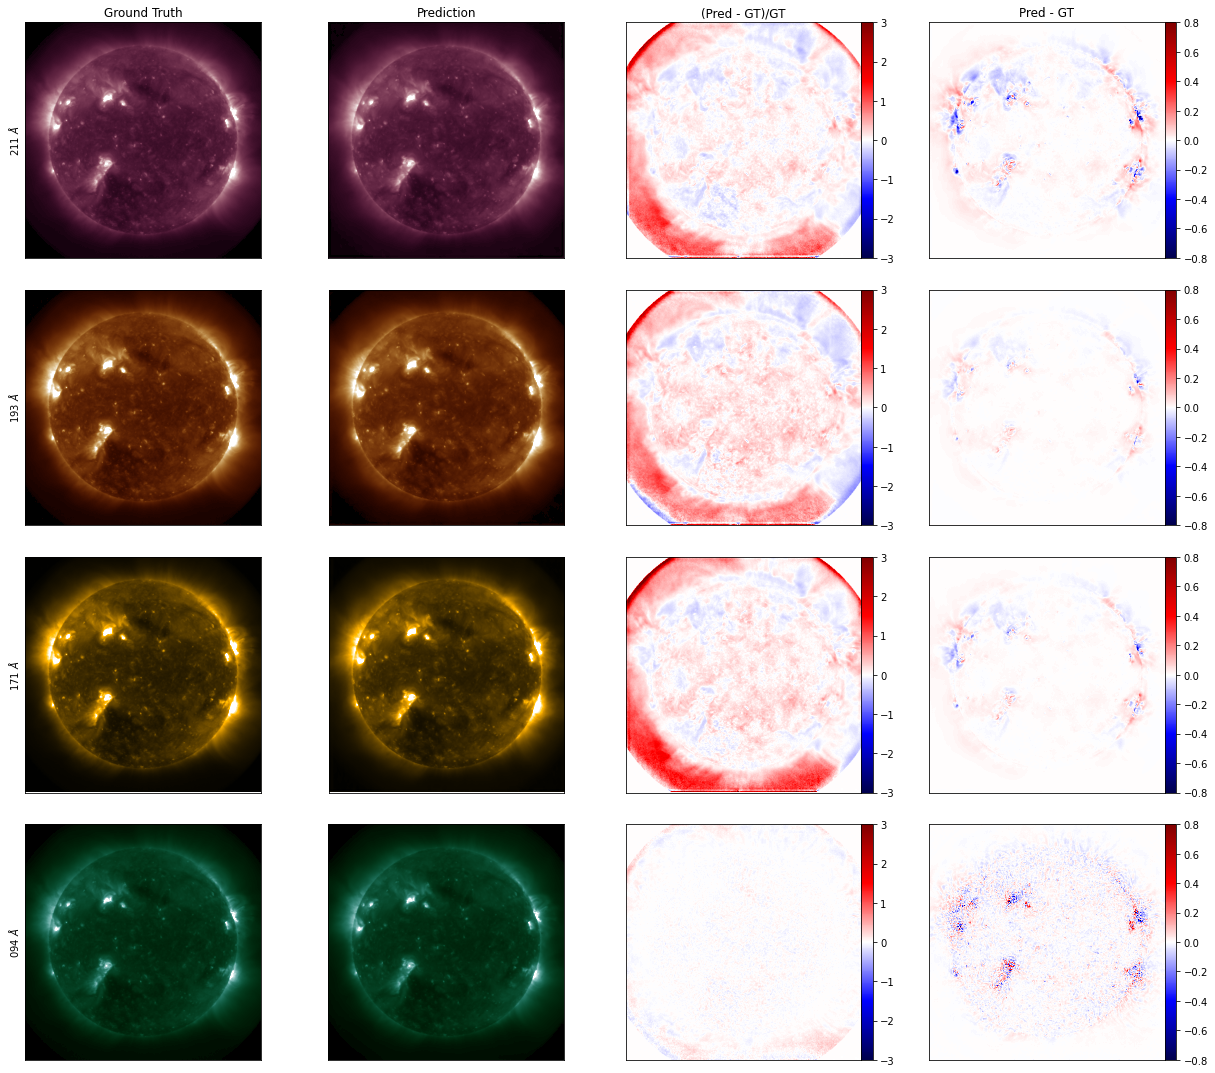

/tmp/ipykernel_15985/4269057629.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)


In [9]:
gamma = {'094':0.7, '171':0.6, '193':0.7, '211':0.7}
vmax = {'094':8, '171':1, '193':0.7, '211':2}
fig = plot_4ch_grid(nr_preditions_quiet_dict, ch_dict, gamma, vmax, model_key="model_nr")
filename = f"{output_path}/real_vs_pred_quiet_nr.png"
fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)

/tmp/ipykernel_15985/669641766.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
/tmp/ipykernel_15985/669641766.py:27: RuntimeWarning: divide by zero encountered in true_divide
  img = (pred - gt_img)/gt_img
/tmp/ipykernel_15985/669641766.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.arange((img.shape[0]), dtype=np.float) - img.shape[0] / 2 + 0.5
/tmp/ipykernel_15985/669641766.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wil

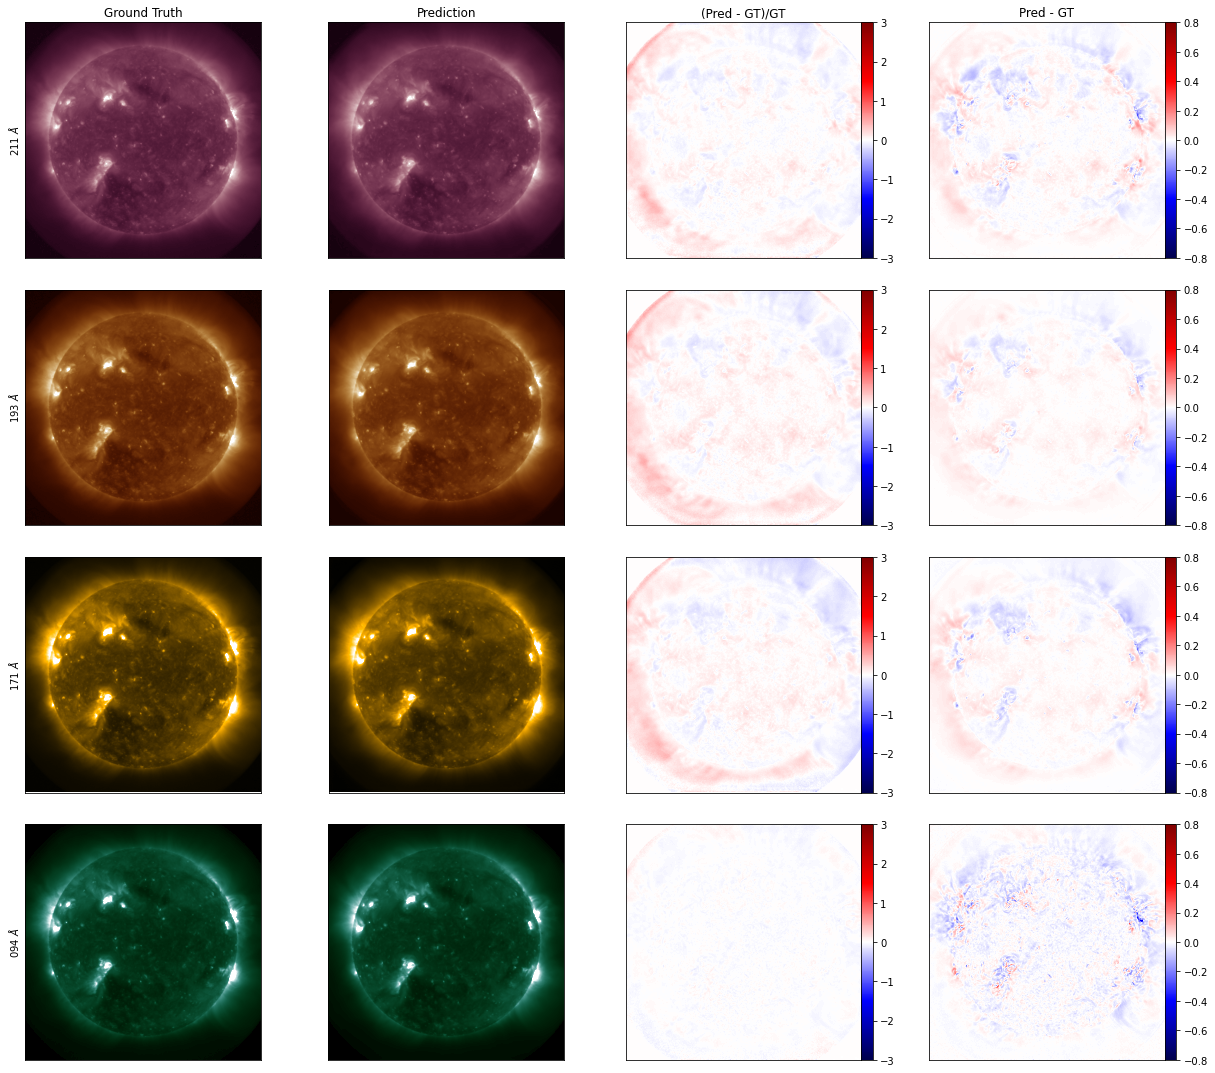

/tmp/ipykernel_15985/4152355404.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)


In [10]:
gamma = {'094':1.5, '171':1, '193':1, '211':1}
vmax = {'094':7, '171':1, '193':1, '211':2}
fig = plot_4ch_grid(root_predictions_quiet_dict, ch_dict_root, gamma, vmax, model_key="model_root")
filename = f"{output_path}/real_vs_pred_quiet_root.png"
fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)

## Images on active Sun

In [11]:
active_day = '2011-02-15 02:00:00'

### Load ground truth images and predictions

In [12]:
nr_prediction_active_dict = load_predictions(active_day, ch_dict, "model_nr")
root_prediction_active_dict = load_predictions(active_day, ch_dict_root, "model_root")

### If you want to recalculate the prediction for quiet day, please run the following cell.

In [13]:
# # #This functions will compute the predictions for each model and channel. If you have saved predictions, you can commment this cell.
# nr_prediction_active = compute_predictions(ch_dict, nr_prediction_active_dict, "model_nr")
# root_prediction_active = compute_predictions(ch_dict_root, root_prediction_active_dict, "model_root")


# with open(f'{working_directory}/Fig4_Active_NR_data_new.pkl', 'wb') as output:
#     pickle.dump(nr_prediction_active, output)
# with open(f'{working_directory}/Fig4_Active_ROOT_data_new.pkl', 'wb') as output:
#     pickle.dump(root_prediction_active, output)

### Plot images

/tmp/ipykernel_15985/669641766.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
/tmp/ipykernel_15985/669641766.py:27: RuntimeWarning: divide by zero encountered in true_divide
  img = (pred - gt_img)/gt_img
/tmp/ipykernel_15985/669641766.py:27: RuntimeWarning: invalid value encountered in true_divide
  img = (pred - gt_img)/gt_img
/tmp/ipykernel_15985/669641766.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.arange((img.shape[0]), dtype=np.float) - img.shape[0] / 2 + 0.5
/tmp/ipykernel_15985/669641766.py:31: DeprecationWar

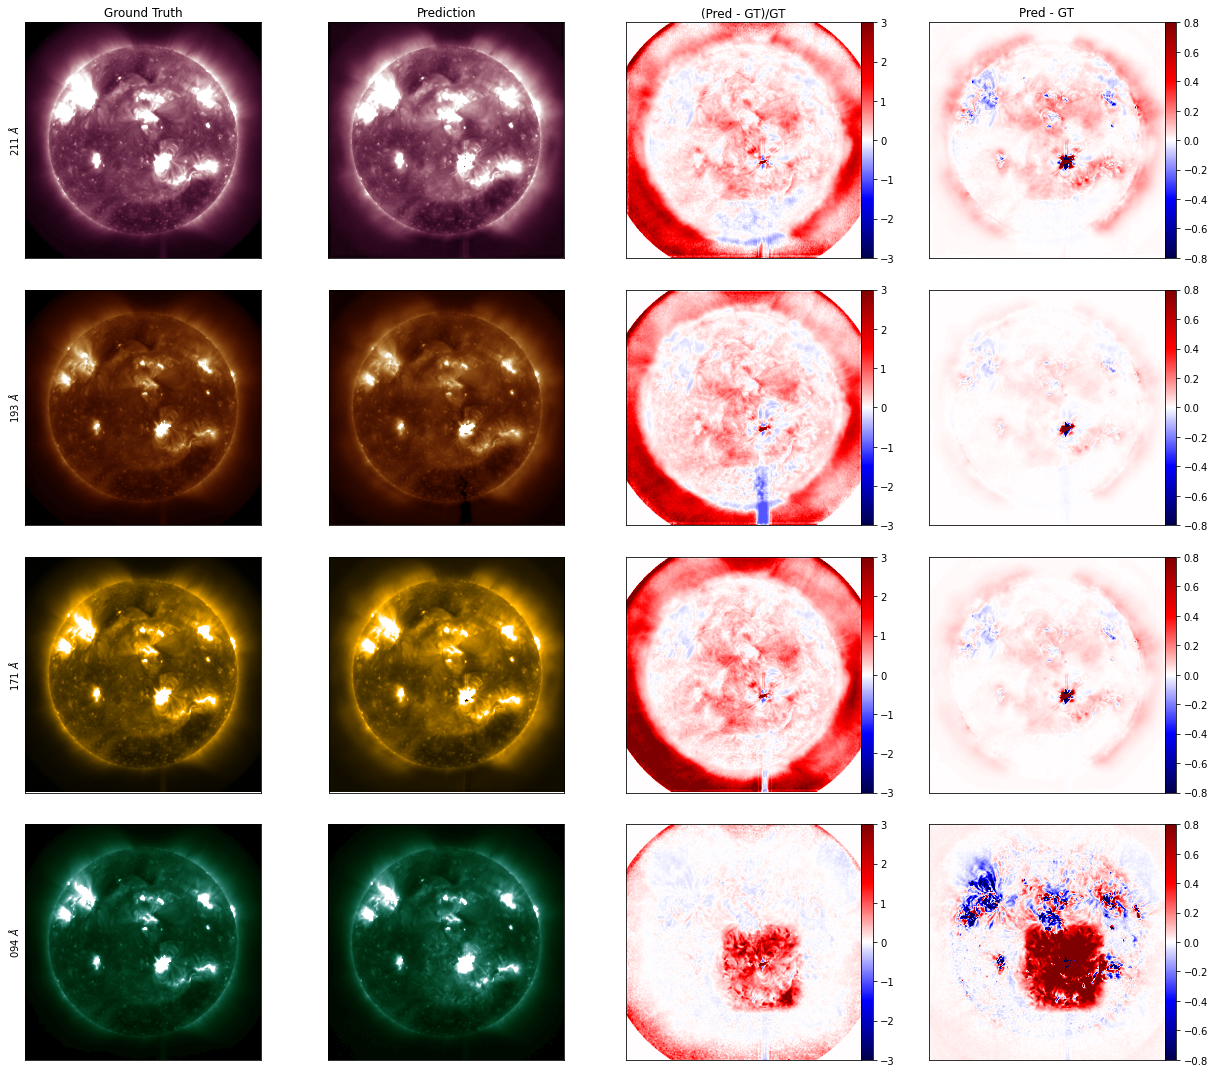

/tmp/ipykernel_15985/2725143354.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)


In [14]:
gamma = {'094':1, '171':0.6, '193':0.8, '211':0.9}
vmax = {'094':8, '171':0.8, '193':0.8, '211':0.8}
fig = plot_4ch_grid(nr_prediction_active_dict, ch_dict, gamma, vmax, model_key="model_nr")
filename = f"{output_path}/real_vs_pred_active_nr.png"
fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)


/tmp/ipykernel_15985/669641766.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
/tmp/ipykernel_15985/669641766.py:27: RuntimeWarning: divide by zero encountered in true_divide
  img = (pred - gt_img)/gt_img
/tmp/ipykernel_15985/669641766.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.arange((img.shape[0]), dtype=np.float) - img.shape[0] / 2 + 0.5
/tmp/ipykernel_15985/669641766.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wil

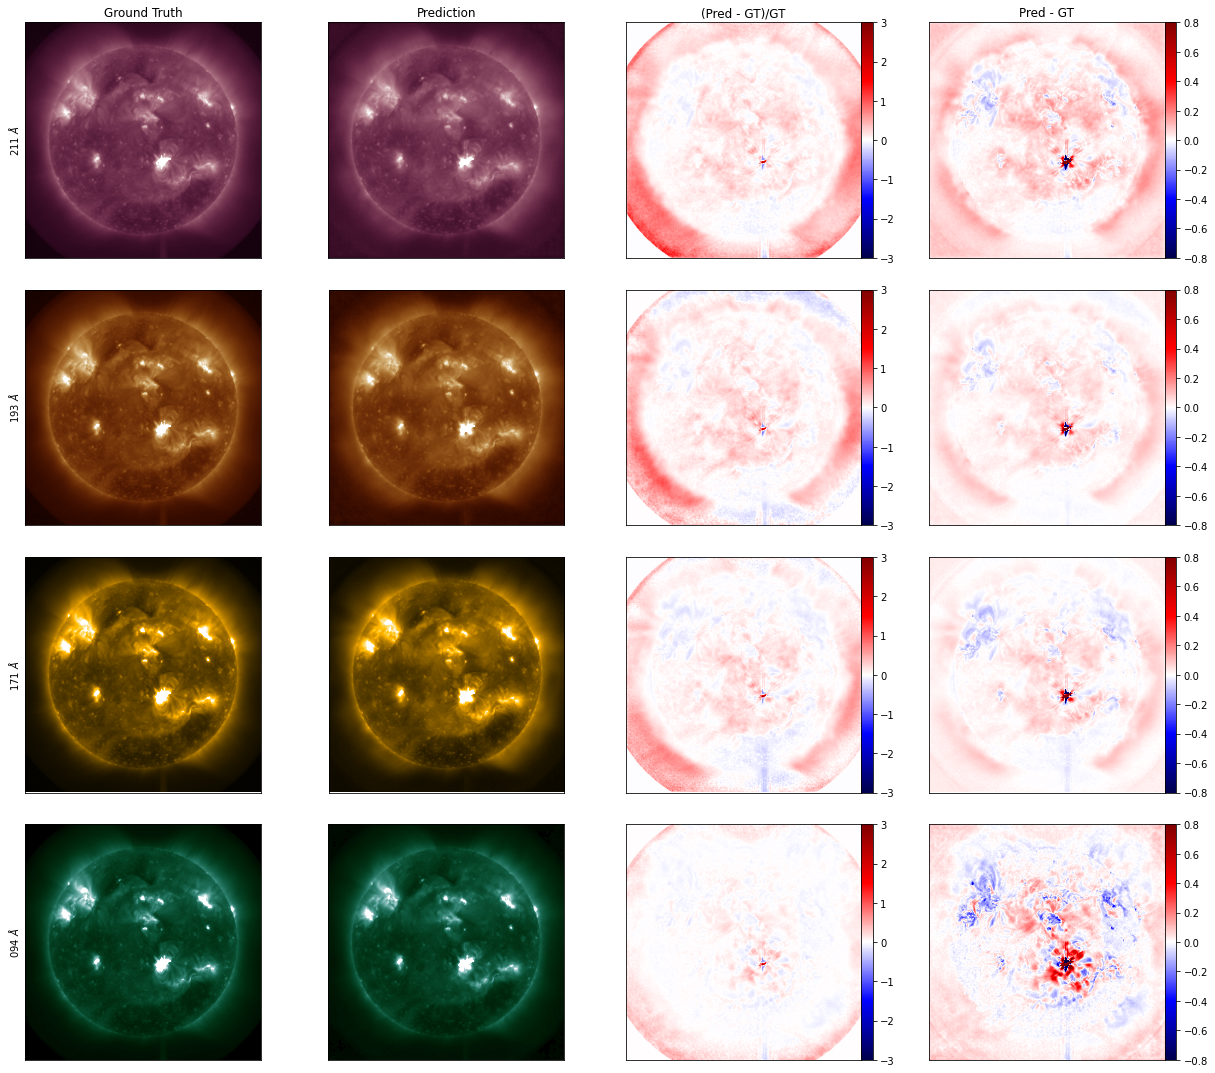

/tmp/ipykernel_15985/3448528860.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)


In [15]:
gamma = {'094':1.5, '171':1, '193':1, '211':1}
vmax = {'094':7, '171':1, '193':1, '211':2}
fig = plot_4ch_grid(root_prediction_active_dict, ch_dict_root, gamma, vmax, model_key="model_root")
filename = f"{output_path}/real_vs_pred_active_root.png"
fig.savefig(filename, tight_layout=True, bbox_inches='tight', dpi=300)